<a href="https://colab.research.google.com/github/gapigo/theras-frontend/blob/price-Modelo_1/modelo1_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeiro modelo de predições para ações da bolsa de valores brasileira, esse modelo consegue **prever uma cotação**, ou seja a **primeira cotação da semana**
como o modelo *não conseguiu prever equivalente a 3 meses*, está sendo descartado, pois não é aplicado a longo prazo, todavía será reutilizado no próximo modelo.

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


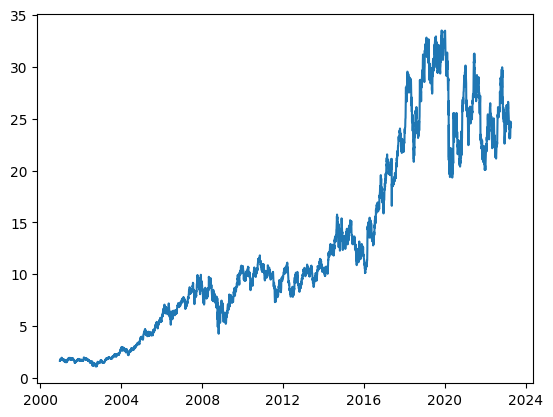

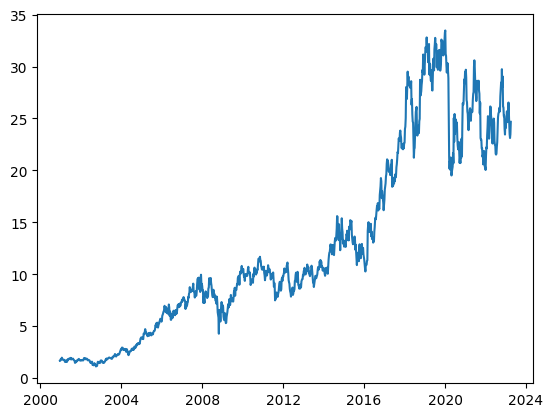

                                Open
Date                                
2000-12-18 00:00:00-02:00   1.658704
2000-12-25 00:00:00-02:00   1.668557
2001-01-01 00:00:00-02:00   1.804637
2001-01-08 00:00:00-02:00   1.833901
2001-01-15 00:00:00-02:00   1.794882
...                              ...
2023-03-06 00:00:00-03:00  24.146163
2023-03-13 00:00:00-03:00  23.484218
2023-03-20 00:00:00-03:00  23.118666
2023-03-27 00:00:00-03:00  23.483234
2023-04-03 00:00:00-03:00  24.680000

[1164 rows x 1 columns]


In [2]:

import yfinance
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from datetime import timedelta
import tensorflow

empresa = "itub4.SA" #Empresa que estamos utilizando para previsão
acao = yfinance.Ticker(empresa) 
primeirografico = acao.history(period='max') #pegamos todos os dados que a empresa possui
#print(primeirografico) #podemos visualizar os dados
plt.plot(primeirografico['Open']) #podemos visualizar o gráfico com todos os dados de ações (finais) que aquela empresa possui
plt.show()
hist = acao.history(period='max',interval="1wk") #então reduzimos a quantidade de dados sem alterar a estrutura gráfico, antes existia muita sujeira, pois as cotações eram diarias
#print(hist) #podemos visualizar esses dados
      #caso eu nao queira todos os dados da ação, mas sim os dados de um certo tempo
          #("^NSEI", start="2020-11-30", end="2022-02-27",interval="1wk") 

plt.plot(hist['Open']) #visualizo o novo gráfico com dados semanais de todas as cotações ja existentes pelo yfinance
plt.show()
tam_dados_acao = len(hist) #determino o tamanho dos meus dados
#testes:
        #hist['Close']
        #hist.index[2]
        #hist
        #dias_da_semana = list()
        #for a in range(len(hist.index)):
        #  dias_da_semana.append(hist.index[a].to_pydatetime().date().weekday())
        #hist['dias_da_semana'] = dias_da_semana


hist = hist.drop(columns=['Close','High','Low','Volume','Dividends','Stock Splits']) #removo os dados desnecessarios para minha IA
print(hist)
#testes:
        #filtro  = hist['dias_da_semana'] == 4
        #data = hist.index[0].to_pydatetime().date()
        #hist = hist.query('dias_da_semana==4')
        #hist
        #print(data)



In [3]:
cotacao = hist.to_numpy().reshape(-1,1) #adiciona os valores de cotaçao a um array numpy e adiciona cada valor a um array
#isso por que necessitamos de valores vetoriais para trabalhar na IA

tam_dados_treinamento = int(len(cotacao)*0.8) 
#separamos os valores de treinamento por padrão o ideal é separar 80%
#20% utilizamos para testar o modelo treinado
#é ideal separar valores de treinamento antes de compilar a ia para evitar overfit
#overfit: sobre-ajuste - quando um modelo estatístico se ajusta muito bem ao conjunto de dados anteriormente observado, 
#mas se mostra ineficaz para prever novos resultados.
      #para visualização:
#print(cotacao[:5])
#print(len(cotacao))
#print(tam_dados_treinamento)

In [4]:
escala = MinMaxScaler(feature_range=(0,1)) 
#'''crio um escalador entre 0 e 1, por que eu necessito transformar meus valores do mundo real em uma escala menor a nivel eletronico entre 0 e 1'''
      #para visualização:
#print(type(escala))

#escalaremos os dados de treino em uma escala de 0 e 1 
dados_0e1_treinamento = escala.fit_transform(cotacao[0:tam_dados_treinamento, :])

#depois de escalar a primeira parte ou seja os 80% escalaremos o restante 
dados_0e1_teste = escala.transform(cotacao[tam_dados_treinamento: , :])
      #para visualização:
#print(dados_0e1_treinamento[:5])
#print(dados_0e1_teste[:5])

In [5]:
#agora necessitamos juntar nossos dados já que fizemos a transformação
dados_0e1 = list(dados_0e1_treinamento.reshape(len(dados_0e1_treinamento))) + list(dados_0e1_teste.reshape(len(dados_0e1_teste)))

dados_0e1 = np.array(dados_0e1).reshape(len(dados_0e1),1)

dados_treinamento = dados_0e1[0:tam_dados_treinamento, :]

#dados que serao usados para gerar resultado:
treinamento_x = []

#cotacao que aconteceu de fato:
treinamento_y = []
teste = 100 #variavel determina a cada quantas cotações será previsto um novo valor
#através desse for, os dados são adicionados nos arrays, assim teremos n valores para 1 valor de previsão
#adicionamos n valores no treinamento_x e adicionamos o valor n+1 para o treinamento_y
for i in range (teste, len(dados_treinamento)):

 
  treinamento_x.append(dados_treinamento[i - teste: i , 0])

  
  treinamento_y.append(dados_treinamento[i,0])
      #para visualização:
  #if i <= teste+1:
    #print(f'essas 4 cotações: {treinamento_x}')
    #print(f'geraram: {treinamento_y}')

In [6]:
treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)
treinamento_x = treinamento_x.reshape(treinamento_x.shape[0],treinamento_x.shape[1],1)

Vamos iniciar a construção do modelo, os parametros adicionados nesse modelo se tratam de uma questão de teste, temos que analisar os parametros que nos trará o melhor resultado.

In [7]:
#construção do nosso modelo
#construção do funcionamento dos neuroneos

modelo = Sequential()
#LSTM é uma camada especializada em processar sequências de dados, como texto, áudio ou séries temporais. Essa camada possui uma memória 
#interna que permite que a rede "lembre" de informações anteriores e, assim, possa fazer previsões mais precisas em dados sequenciais. 
#A camada LSTM é composta por três portões (gateways) - entrada, esquecimento e saída - que permitem que a rede aprenda quais informações são 
#importantes de lembrar e quais podem ser esquecidas. Essa camada é especialmente útil para resolver problemas de predição de séries temporais, 
#como previsão de valores futuros de ações na bolsa de valores.
#LSTM input_shape -> definição de que a cada treinamento_x.shape[1] ou seja a cada um conjunto de n valores == teste vou gerar um valor
#LSTM return_sequences -> resumidamente conecta os lstm
modelo.add(LSTM(60, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))

modelo.add(LSTM(60, return_sequences=False))
#A camada Dense é a camada mais simples e básica de uma rede neural, também conhecida como camada totalmente conectada. Ela é composta por um conjunto 
#de neurônios conectados a todos os neurônios da camada anterior e todos os neurônios da camada seguinte, criando uma rede densa de conexões. Essa camada 
#é usada para transformar a entrada de dados em uma saída de dados por meio de uma operação linear, seguida por uma função de ativação.
modelo.add(Dense(120))

modelo.add(Dense(240))
modelo.add(Dropout(0.25))
modelo.add(Dense(120))

modelo.add(Dense(1))

treinamento_x.shape[1]

100

In [8]:
#compilar o modelo

#optimizer = Adao -> A otimização de Adam é um método de descida de gradiente estocástico baseado na estimativa 
#adaptativa de momentos de primeira e segunda ordem.
#ele faz a melhoria do modelo, podemos definir a quantidade de ajustes nas melhorias que queremos

#loss = medidor de erro( nesse caso é o erro médio quadratico )
modelo.compile(optimizer="adam", loss="mean_squared_error")

In [9]:
#podemos agora treinar o modelo 
#batch_size = define de quantas em quantas amostras o modelo se optimiza
#epochs = quantas vezes serão rodado os dados de treinamento, ou seja a cada execução ele fará uma melhoria em si mesmo, chega um momento que ele já nao consegue se melhorar
#para controlar o modelo vamos aumentar a epochs ou seja a quantidade de vezes que ele se melhora e adicionar uma função (callback) que vai controlar
#o modelo, ou seja, quando ele nao conseguir mais melhoraar ele vai parar de executar
#explicando algumas coisas:
#A função EarlyStopping permite a definição de vários parâmetros que controlam o comportamento do Early Stopping. 
#Aqui estão os principais parâmetros que podem ser usados:
#monitor: a métrica a ser monitorada durante o treinamento. Pode ser uma das métricas padrão do Keras, como "loss", 
#"acc" ou "val_loss", ou uma métrica personalizada definida pelo usuário.
#patience: o número de épocas sem melhora na métrica monitorada antes de interromper o treinamento.
#verbose: o nível de detalhe das mensagens de registro. 0 significa silencioso, 1 significa informações básicas e 2 significa informações detalhadas.
#mode: a direção em que a métrica monitorada deve ser melhorada. Pode ser "auto", "min" ou "max". Por exemplo, se a métrica monitorada for a perda (loss), 
#"min" indicaria que a perda deve ser minimizada, enquanto "max" indicaria que a acurácia (accuracy) deve ser maximizada.
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1, mode='min')

#testar com verbose detalhada 2
modelo.fit(treinamento_x, treinamento_y, batch_size=1,epochs=100, callbacks=[early_stop])

Epoch 1/100
831/831 [==============================] - 66s 70ms/step - loss: 0.0089
Epoch 2/100
831/831 [==============================] - 45s 54ms/step - loss: 0.0024
Epoch 3/100
831/831 [==============================] - 46s 55ms/step - loss: 0.0016
Epoch 4/100
831/831 [==============================] - 45s 54ms/step - loss: 0.0017
Epoch 5/100
831/831 [==============================] - 44s 53ms/step - loss: 0.0013
Epoch 6/100
831/831 [==============================] - 43s 52ms/step - loss: 0.0012
Epoch 7/100
831/831 [==============================] - 45s 54ms/step - loss: 9.6045e-04
Epoch 8/100
831/831 [==============================] - 43s 52ms/step - loss: 0.0012
Epoch 9/100
831/831 [==============================] - 44s 53ms/step - loss: 7.5929e-04
Epoch 10/100
831/831 [==============================] - 45s 54ms/step - loss: 0.0011
Epoch 11/100
831/831 [==============================] - 43s 52ms/step - loss: 8.4435e-04
Epoch 12/100
831/831 [==============================] - 45s 54

demorou 45 minutos para executar



Epoch 1/100
874/874 [==============================] - 55s 58ms/step - loss: 0.0058
Epoch 2/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0024
Epoch 3/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0023
Epoch 4/100
874/874 [==============================] - 52s 59ms/step - loss: 0.0017
Epoch 5/100
874/874 [==============================] - 52s 59ms/step - loss: 0.0030
Epoch 6/100
874/874 [==============================] - 51s 59ms/step - loss: 0.0013
Epoch 7/100
874/874 [==============================] - 53s 61ms/step - loss: 0.0013
Epoch 8/100
874/874 [==============================] - 52s 60ms/step - loss: 0.0014
Epoch 9/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0013
Epoch 10/100
874/874 [==============================] - 50s 57ms/step - loss: 0.0014
Epoch 11/100
874/874 [==============================] - 50s 58ms/step - loss: 0.0015
Epoch 12/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0014
Epoch 13/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0012
Epoch 14/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0013
Epoch 15/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0012
Epoch 16/100
874/874 [==============================] - 50s 58ms/step - loss: 0.0012
Epoch 17/100
874/874 [==============================] - 50s 58ms/step - loss: 0.0011
Epoch 18/100
874/874 [==============================] - 52s 60ms/step - loss: 0.0011
Epoch 19/100
874/874 [==============================] - 53s 61ms/step - loss: 0.0010
Epoch 20/100
874/874 [==============================] - 52s 60ms/step - loss: 0.0014
Epoch 21/100
874/874 [==============================] - 52s 59ms/step - loss: 0.0011
Epoch 22/100
874/874 [==============================] - 52s 59ms/step - loss: 0.0011
Epoch 23/100
874/874 [==============================] - 50s 57ms/step - loss: 9.8022e-04
Epoch 24/100
874/874 [==============================] - 50s 57ms/step - loss: 0.0015
Epoch 25/100
874/874 [==============================] - 50s 57ms/step - loss: 0.0010
Epoch 26/100
874/874 [==============================] - 49s 56ms/step - loss: 0.0011
Epoch 27/100
874/874 [==============================] - 49s 56ms/step - loss: 0.0010
Epoch 28/100
874/874 [==============================] - 50s 58ms/step - loss: 9.3305e-04
Epoch 29/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0010
Epoch 30/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0010
Epoch 31/100
874/874 [==============================] - 51s 58ms/step - loss: 9.2406e-04
Epoch 32/100
874/874 [==============================] - 51s 58ms/step - loss: 9.5341e-04
Epoch 33/100
874/874 [==============================] - 51s 58ms/step - loss: 9.4310e-04
Epoch 34/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0012
Epoch 35/100
874/874 [==============================] - 51s 58ms/step - loss: 9.1131e-04
Epoch 36/100
874/874 [==============================] - 50s 57ms/step - loss: 0.0010
Epoch 37/100
874/874 [==============================] - 50s 58ms/step - loss: 0.0012
Epoch 38/100
874/874 [==============================] - 50s 57ms/step - loss: 9.8660e-04
Epoch 39/100
874/874 [==============================] - 50s 58ms/step - loss: 8.4077e-04
Epoch 40/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0011
Epoch 41/100
874/874 [==============================] - 52s 59ms/step - loss: 9.2023e-04
Epoch 42/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0011
Epoch 43/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0011
Epoch 44/100
874/874 [==============================] - 51s 58ms/step - loss: 7.8873e-04
Epoch 45/100
874/874 [==============================] - 51s 59ms/step - loss: 8.6744e-04
Epoch 46/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0012
Epoch 47/100
874/874 [==============================] - 51s 58ms/step - loss: 8.3255e-04
Epoch 48/100
874/874 [==============================] - 51s 58ms/step - loss: 8.9093e-04
Epoch 49/100
874/874 [==============================] - 49s 56ms/step - loss: 8.7406e-04
Epoch 50/100
874/874 [==============================] - 49s 56ms/step - loss: 8.4380e-04
Epoch 51/100
874/874 [==============================] - 50s 57ms/step - loss: 9.4944e-04
Epoch 52/100
874/874 [==============================] - 51s 58ms/step - loss: 8.8810e-04
Epoch 53/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0010
Epoch 54/100
874/874 [==============================] - 51s 58ms/step - loss: 0.0013
Epoch 54: early stopping
<keras.callbacks.History at 0x7f4d601dd4c0>

In [10]:
#teste do modelo

dados_teste = dados_0e1[tam_dados_treinamento - teste:, :]

teste_x = []
teste_y = cotacao[tam_dados_treinamento: , :]

for i in range(teste, len(dados_teste)):
  teste_x.append(dados_teste[i - teste: i,0])

In [11]:
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1],1)

In [12]:
predicoes = modelo.predict(teste_x)

predicoes = escala.inverse_transform(predicoes)


8/8 [==============================] - 1s 32ms/step


In [13]:
#remover o erro medio quadratico

remo_erro_quadra = np.sqrt(np.mean(predicoes - teste_y)**2)
remo_erro_quadra #erro em reais
#primeiro modelo = 2,80
#segundo modelo = 1.94
#modelo com dias da semana = 1,70
#antigo
#0.13428329734645264
#depois de ultima melhoria 
#0.8783211374479066

1.8471934934042649

In [14]:
treinamento = hist.iloc[:tam_dados_treinamento,:]
df_teste = pd.DataFrame({"Open":hist["Open"].iloc[tam_dados_treinamento:],"predicoes":predicoes.reshape(len(predicoes))})

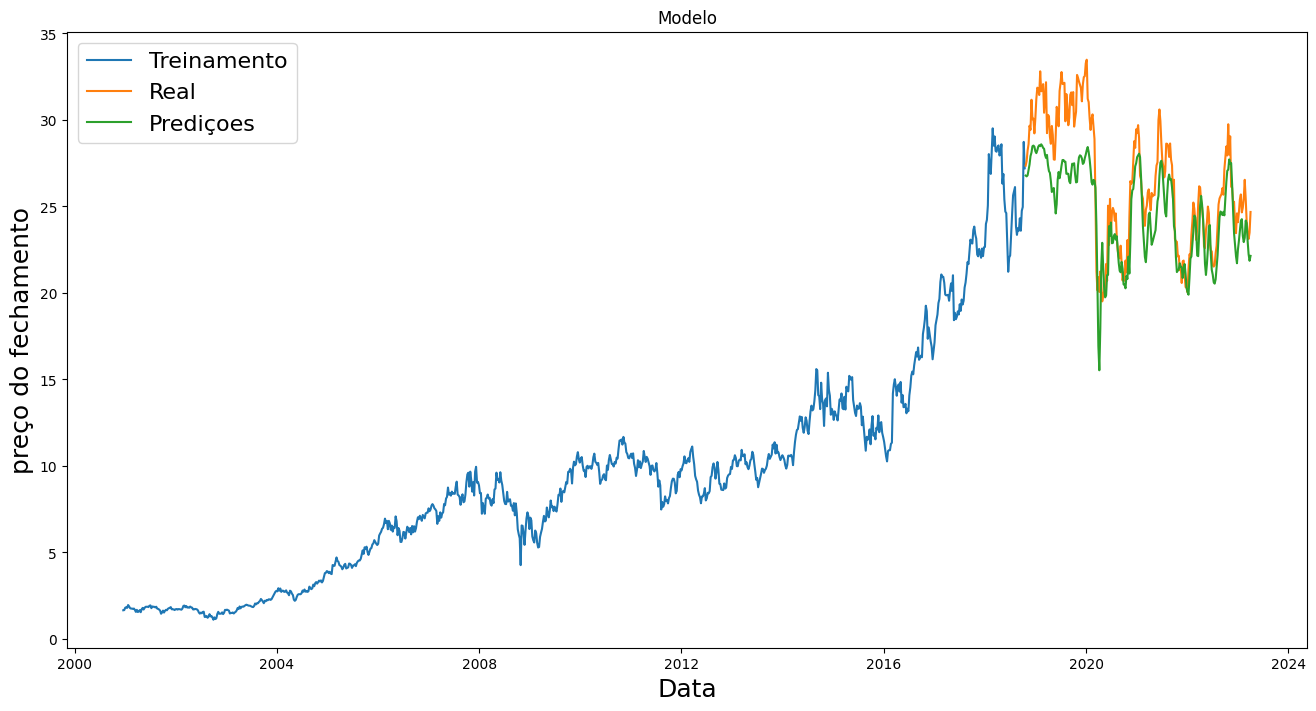

In [15]:
plt.figure(figsize = (16,8))
plt.title('Modelo')
plt.xlabel('Data',fontsize = 18)
plt.ylabel('preço do fechamento', fontsize = 18)
plt.plot(treinamento['Open'])
plt.plot(df_teste[['Open','predicoes']])
plt.legend(['Treinamento', 'Real', 'Prediçoes'], loc=2, prop={'size':16})
plt.show()

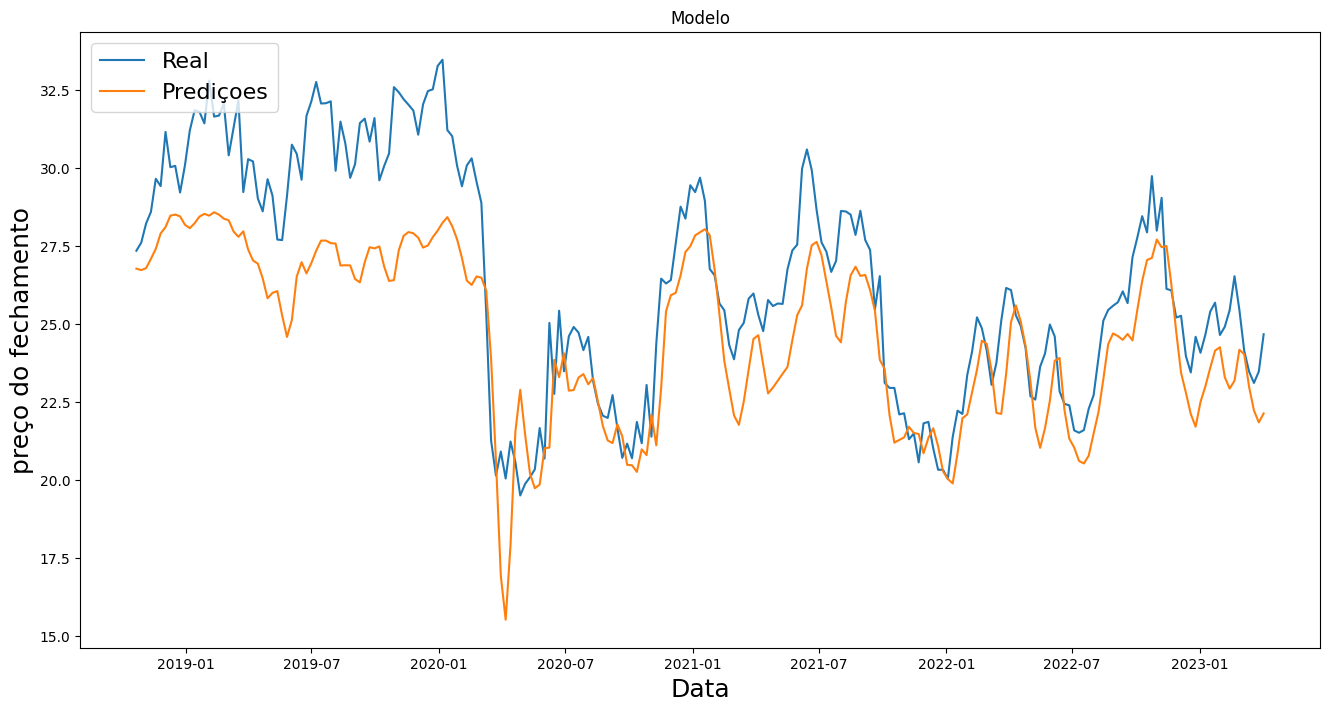

In [16]:
plt.figure(figsize = (16,8))
plt.title('Modelo')
plt.xlabel('Data',fontsize = 18)
plt.ylabel('preço do fechamento', fontsize = 18)
#plt.plot(treinamento['Close'])
plt.plot(df_teste[['Open','predicoes']])
plt.legend([ 'Real', 'Prediçoes'], loc=2, prop={'size':16})
plt.show()

In [17]:
df_teste.sort_index()
df_teste

,Open,predicoes
Date,,
2018-10-22 00:00:00-03:00,27.356726,26.781916
2018-10-29 00:00:00-03:00,27.616360,26.736551
2018-11-05 00:00:00-02:00,28.228865,26.797310
2018-11-12 00:00:00-02:00,28.601496,27.098427
2018-11-19 00:00:00-02:00,29.662888,27.418962
...,...,...
2023-03-06 00:00:00-03:00,24.146163,24.037209
2023-03-13 00:00:00-03:00,23.484218,22.994465
2023-03-20 00:00:00-03:00,23.118666,22.235174


In [18]:
from datetime import date, timedelta

data = date.today()

quant_dias = 12
lista_seg = []

while len(lista_seg) < quant_dias:
  if data.weekday() == 0:
    lista_seg.append(data)

  data += timedelta(days=1)

for idx in range(0, len(lista_seg)):
  print(f'[{idx + 1}] ', lista_seg[idx])

    #0 --  Segunda-feira',
    #1 -- Terça-feira',
    #2  -- Quarta-feira',
    #3 -- Quinta-Feira',
    #4 -- Sexta-feira',
    #5 -- Sábado',
    #6 -- Domingo']"""
#lista_seg[0] = np.datetime64(lista_seg[0])
print(type(lista_seg[0]))

[1]  2023-04-10
[2]  2023-04-17
[3]  2023-04-24
[4]  2023-05-01
[5]  2023-05-08
[6]  2023-05-15
[7]  2023-05-22
[8]  2023-05-29
[9]  2023-06-05
[10]  2023-06-12
[11]  2023-06-19
[12]  2023-06-26
<class 'datetime.date'>


Para prever o valor da próxima semana execute o código abaixo

In [19]:
ultimas_4semanas = hist['Open'].iloc[-teste:].values.reshape(-1,1)
  #print(ultimas_4semanas)
ultimas_4semanas_escalado = escala.transform(ultimas_4semanas)

teste_x = []
teste_x.append(ultimas_4semanas_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1],1)
previsao_amanha = modelo.predict(teste_x)
previsao_amanha = escala.inverse_transform(previsao_amanha)
#data_teste = datetime.strptime(str(lista_seg[a]), '%Y-%m-%d')
#hist.loc[str(lista_seg[a])]=float(previsao_amanha[0])
#print(hist['Close'][len(hist['Close'])-1])

           
print(previsao_amanha)

1/1 [==============================] - 0s 39ms/step
[[23.284058]]


Código que força o modelo a prever 12 semanas !!!!!não funcional!!!!!

In [20]:
from datetime import date


for a in range(12):
  ultimas_4semanas = hist['Open'].iloc[-teste:].values.reshape(-1,1)
  #print(ultimas_4semanas)
  ultimas_4semanas_escalado = escala.transform(ultimas_4semanas)

  teste_x = []
  teste_x.append(ultimas_4semanas_escalado)
  teste_x = np.array(teste_x)
  teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1],1)
  previsao_amanha = modelo.predict(teste_x)
  previsao_amanha = escala.inverse_transform(previsao_amanha)
  #data_teste = datetime.strptime(str(lista_seg[a]), '%Y-%m-%d')
  hist.loc[str(lista_seg[a])]=float(previsao_amanha[0])
  print(hist['Open'][len(hist['Open'])-1])

           
print(hist.index)

1/1 [==============================] - 0s 33ms/step
23.2840576171875
1/1 [==============================] - 0s 33ms/step
23.009965896606445
1/1 [==============================] - 0s 34ms/step
22.437179565429688
1/1 [==============================] - 0s 39ms/step
21.900415420532227
1/1 [==============================] - 0s 33ms/step
21.373994827270508
1/1 [==============================] - 0s 36ms/step
20.890026092529297
1/1 [==============================] - 0s 34ms/step
20.474714279174805
1/1 [==============================] - 0s 33ms/step
20.149389266967773
1/1 [==============================] - 0s 33ms/step
19.92085838317871
1/1 [==============================] - 0s 43ms/step
19.771926879882812
1/1 [==============================] - 0s 39ms/step
19.67125701904297
1/1 [==============================] - 0s 34ms/step
19.577829360961914
Index([2000-12-18 00:00:00-02:00, 2000-12-25 00:00:00-02:00,
       2001-01-01 00:00:00-02:00, 2001-01-08 00:00:00-02:00,
       2001-01-15 00:00:00-02:

In [21]:
from datetime import datetime
import re
#hist = hist.reset_index()
#hist['Date'] = hist.Date.apply(str)
#hist.Date = pd.to_datetime(hist.Date)
# convert the datetime object to the desired format
#hist.Date = hist.Date.strftime("%Y-%B-%d")
#hist['Date'] = str(hist.index)
#print(type(hist.index))
# hist['Data'] = str(hist.index)
df2 = hist
# df2
df2['Data'] = df2.index
df2['Data'] = df2['Data'].apply(lambda x: datetime.strptime(re.findall('\d{4}-\d{2}-\d{2}', str(x))[0], '%Y-%m-%d').date())
# df2['Data'] = pd.Series(df2.index.map(str))
type(df2['Data'][0])

# print(str(hist.index))
#hist.Date.apply(lambda x: x.strftime("%Y-%B-%d"))
#hist['Date'] = hist['Date'].apply(lambda x: x.strftime("%Y-%B-%d"))

datetime.date

In [22]:
hist = hist.reset_index()
hist = hist.drop(columns=['Date'])
hist

,Open,Data
0,1.658704,2000-12-18
1,1.668557,2000-12-25
2,1.804637,2001-01-01
3,1.833901,2001-01-08
4,1.794882,2001-01-15
...,...,...
1171,20.149389,2023-05-29
1172,19.920858,2023-06-05
1173,19.771927,2023-06-12
1174,19.671257,2023-06-19


In [23]:
hist[tam_dados_acao:]

,Open,Data
1164,23.284058,2023-04-10
1165,23.009966,2023-04-17
1166,22.437180,2023-04-24
1167,21.900415,2023-05-01
1168,21.373995,2023-05-08
1169,20.890026,2023-05-15
1170,20.474714,2023-05-22
1171,20.149389,2023-05-29
1172,19.920858,2023-06-05
1173,19.771927,2023-06-12


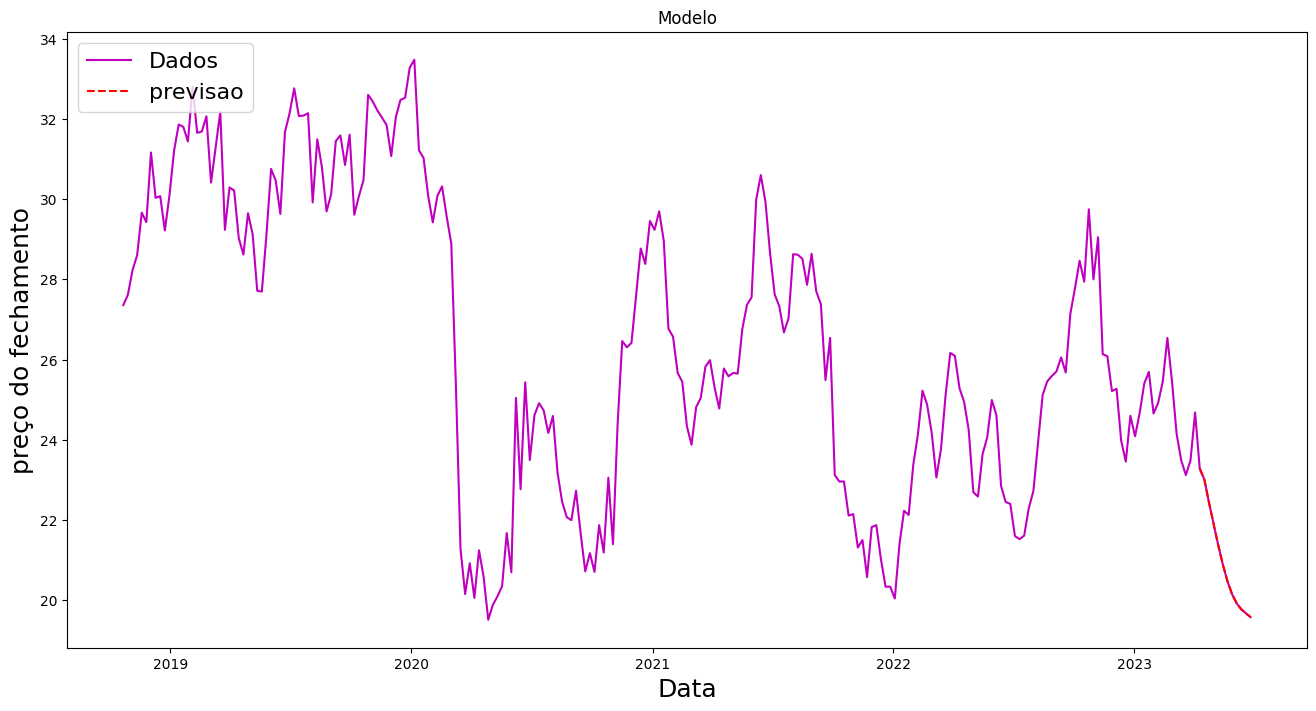

In [24]:
antes_de_prever = hist.iloc[tam_dados_treinamento:,:]
depois_de_prever= hist.iloc[tam_dados_acao:,:]
plt.figure(figsize = (16,8))
plt.title('Modelo')
plt.xlabel('Data',fontsize = 18)
plt.ylabel('preço do fechamento', fontsize = 18)
plt.plot(antes_de_prever['Data'],antes_de_prever['Open'],color='m')
plt.plot(depois_de_prever['Data'],depois_de_prever['Open'],color='r',linestyle='--')
plt.legend(['Dados', 'previsao'], loc=2, prop={'size':16})
plt.show()

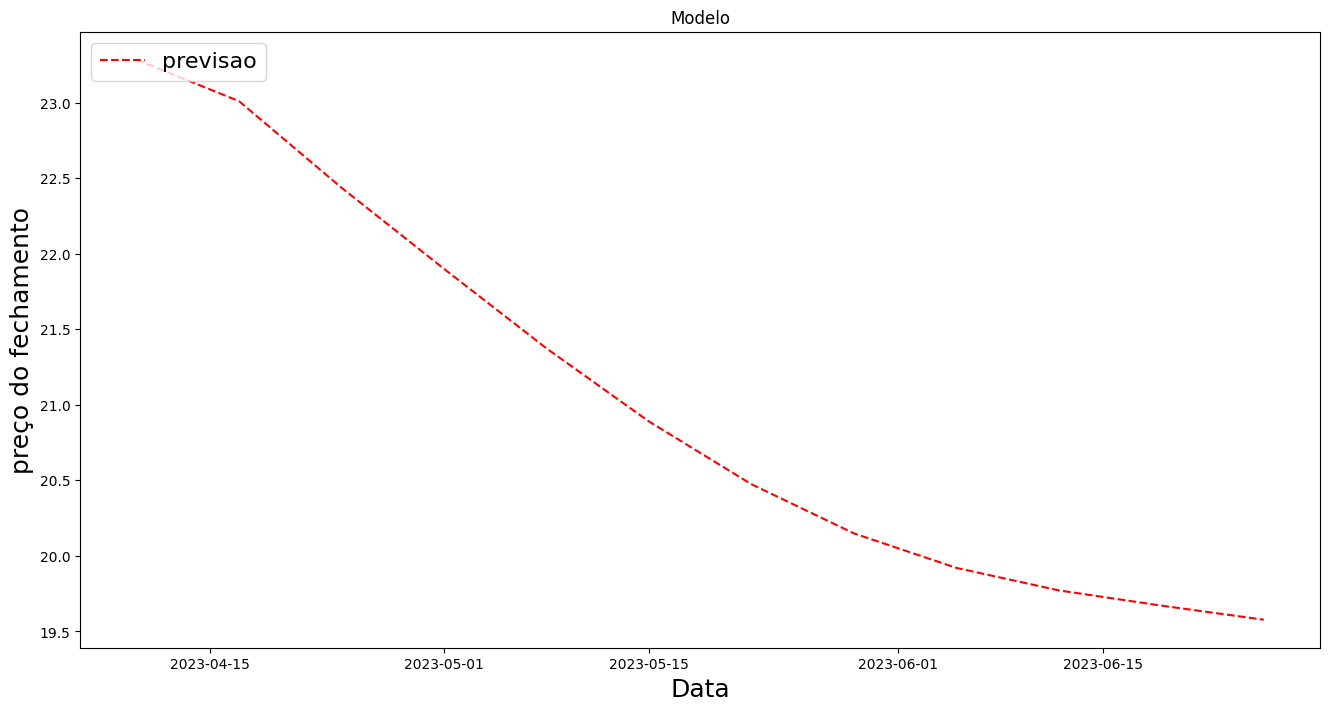

In [25]:
plt.figure(figsize = (16,8))
plt.title('Modelo')
plt.xlabel('Data',fontsize = 18)
plt.ylabel('preço do fechamento', fontsize = 18)
plt.plot(depois_de_prever['Data'][-97:892],depois_de_prever['Open'][-97:892],color='r',linestyle='--')
plt.legend(['previsao'], loc=2, prop={'size':16})
plt.show()

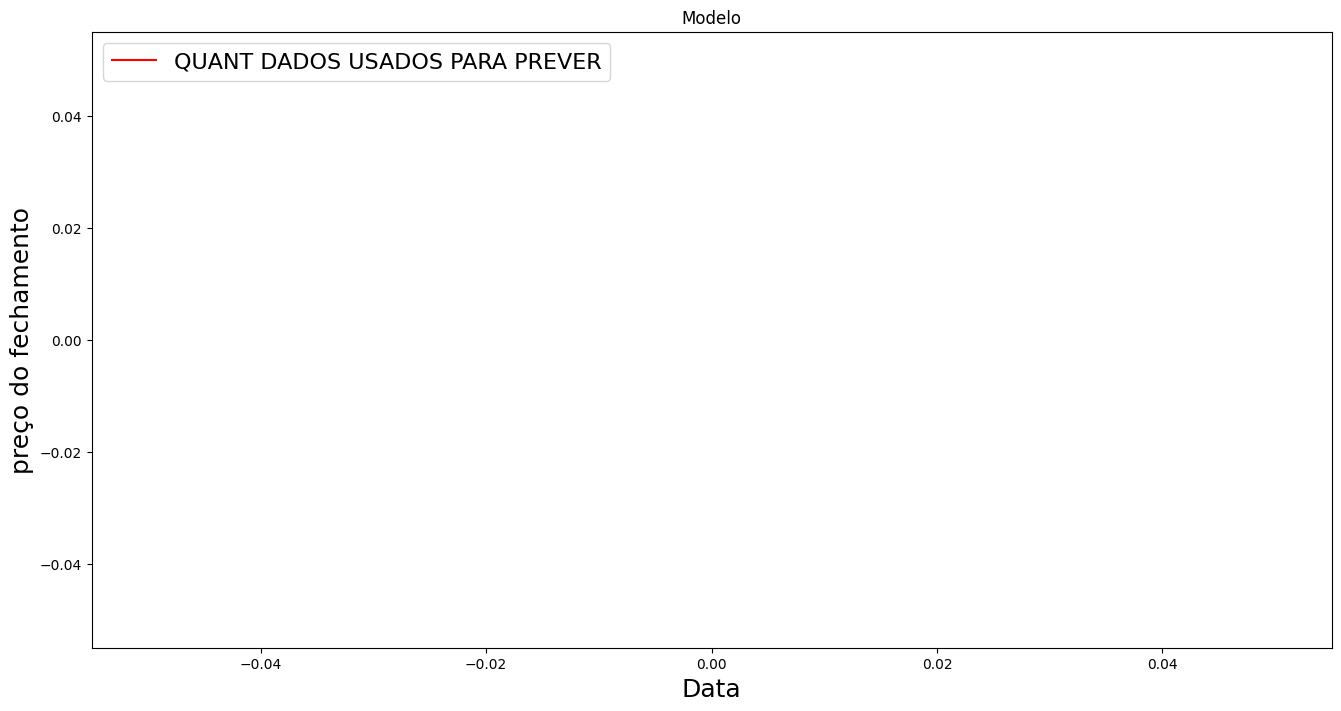

In [26]:

plt.figure(figsize = (16,8))
plt.title('Modelo')
plt.xlabel('Data',fontsize = 18)
plt.ylabel('preço do fechamento', fontsize = 18)
plt.plot(hist['Data'][-100:892],hist['Open'][-100:892],color='r')
plt.legend(['QUANT DADOS USADOS PARA PREVER'], loc=2, prop={'size':16})
plt.show()